In [7]:
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from keras.layers import Input, Dropout, Dense, GlobalAveragePooling2D
from keras.models import Sequential, Model
from keras.applications.resnet import ResNet50
from keras.applications import VGG16, DenseNet121, InceptionV3, VGG19, Xception
from tensorboard import notebook
from tensorflow import keras
import numpy as np
import sys
sys.path.append("/root/autodl-tmp/training_tool/")
from training_tool import load_data, draw_curve, draw_matrix, TimeHistory

100%|██████████| 186/186 [00:00<00:00, 192.72it/s]


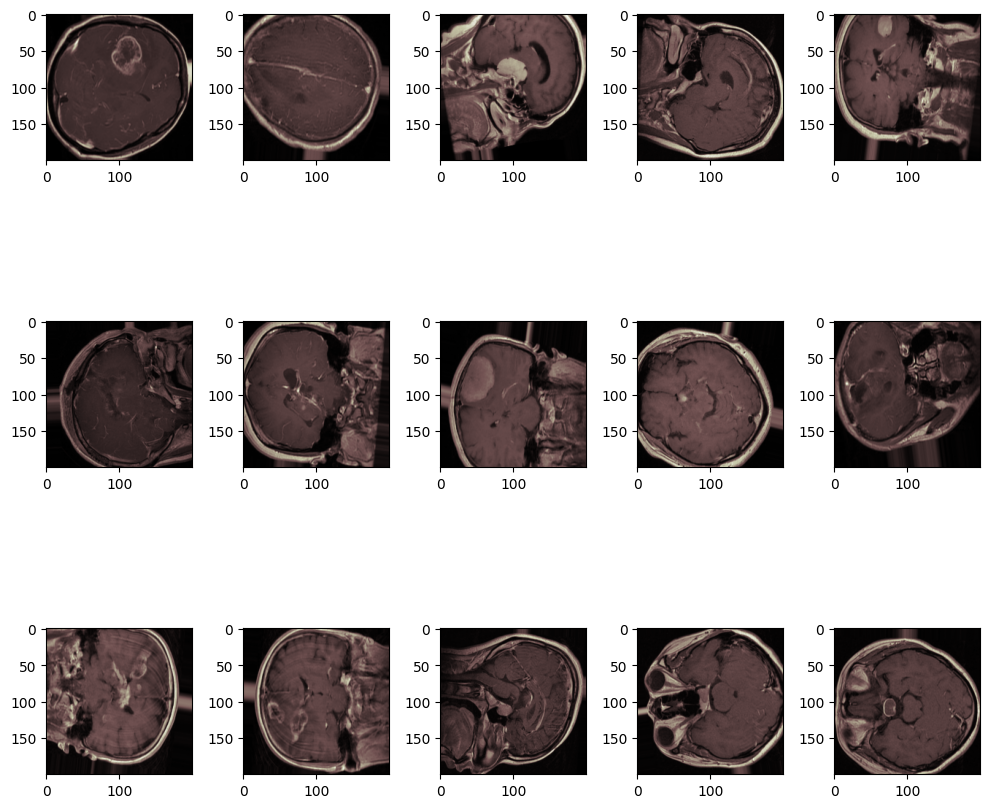

(614, 200, 200, 3)
(10536, 200, 200, 3)
(614, 3)
(10536, 3)


In [2]:
labels = ['glioma', 'meningioma', 'pituitary']
data_path = '/root/autodl-tmp/dataset/figshare_MBTD/augmented'
image_size = 200
x_train, x_test, y_train, y_test = load_data(data_path, labels, image_size)

In [3]:
net = InceptionV3(weights=None, include_top=False, input_shape=(image_size, image_size, 3))

model = net.output
model = GlobalAveragePooling2D()(model)
model = Dropout(0.5)(model)
model = Dense(3, activation="softmax")(model)
model = Model(inputs=net.input, outputs=model)

adam = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

2023-12-08 04:42:54.449039: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-08 04:42:54.763337: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22134 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:01:00.0, compute capability: 8.9


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 200, 200, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 99, 99, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 99, 99, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

In [4]:
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint(filepath='model-InceptionV3.h5',
                             monitor='val_accuracy', verbose=1, save_best_only=False, mode='max')
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 5, min_delta = 0.001,
                              mode='auto',verbose=1)
time_callback = TimeHistory()
history = model.fit(x_train,y_train,validation_split=0.1, epochs =50, verbose=1, batch_size=36,
                   callbacks=[tensorboard,checkpoint,reduce_lr, time_callback])

Epoch 1/50


2023-12-08 04:43:24.372458: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8101
2023-12-08 04:43:24.907247: W tensorflow/stream_executor/gpu/asm_compiler.cc:230] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.9
2023-12-08 04:43:24.907286: W tensorflow/stream_executor/gpu/asm_compiler.cc:233] Used ptxas at ptxas
2023-12-08 04:43:24.907468: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] UNIMPLEMENTED: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2023-12-08 04:43:25.564941: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


264/264 [==============================] - ETA: 0s - loss: 0.8028 - accuracy: 0.6561
Epoch 1: saving model to model-InceptionV3.h5
Epoch 1: 20.09 seconds
264/264 [==============================] - 20s 51ms/step - loss: 0.8028 - accuracy: 0.6561 - val_loss: 4.2562 - val_accuracy: 0.3321 - lr: 1.0000e-04
Epoch 2/50
263/264 [============================>.] - ETA: 0s - loss: 0.5071 - accuracy: 0.7991
Epoch 2: saving model to model-InceptionV3.h5
Epoch 2: 11.48 seconds
264/264 [==============================] - 11s 43ms/step - loss: 0.5069 - accuracy: 0.7991 - val_loss: 2.2497 - val_accuracy: 0.4867 - lr: 1.0000e-04
Epoch 3/50
264/264 [==============================] - ETA: 0s - loss: 0.3765 - accuracy: 0.8584
Epoch 3: saving model to model-InceptionV3.h5
Epoch 3: 11.32 seconds
264/264 [==============================] - 11s 43ms/step - loss: 0.3765 - accuracy: 0.8584 - val_loss: 0.6902 - val_accuracy: 0.7581 - lr: 1.0000e-04
Epoch 4/50
263/264 [============================>.] - ETA: 0s - lo

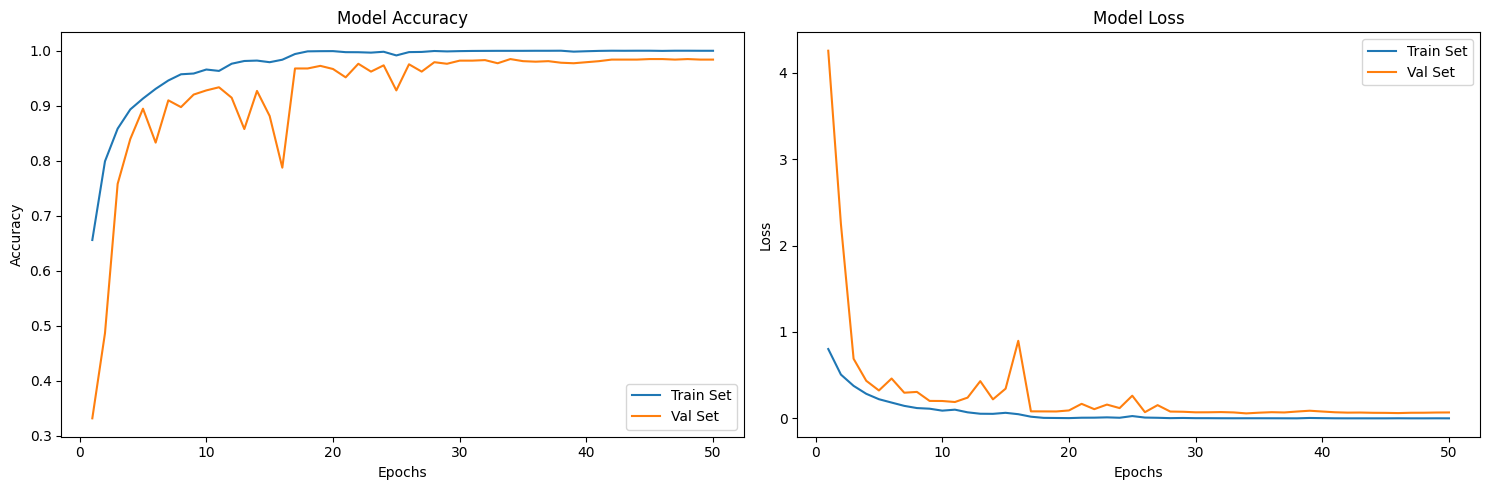

In [5]:
draw_curve(history)

20/20 [==============================] - 0s 15ms/step - loss: 0.2024 - accuracy: 0.9544
Test Accuracy:  95.44
              precision    recall  f1-score   support

      glioma     0.9716    0.9580    0.9648       286
  meningioma     0.9091    0.9155    0.9123       142
   pituitary     0.9630    0.9785    0.9707       186

    accuracy                         0.9544       614
   macro avg     0.9479    0.9507    0.9492       614
weighted avg     0.9545    0.9544    0.9544       614



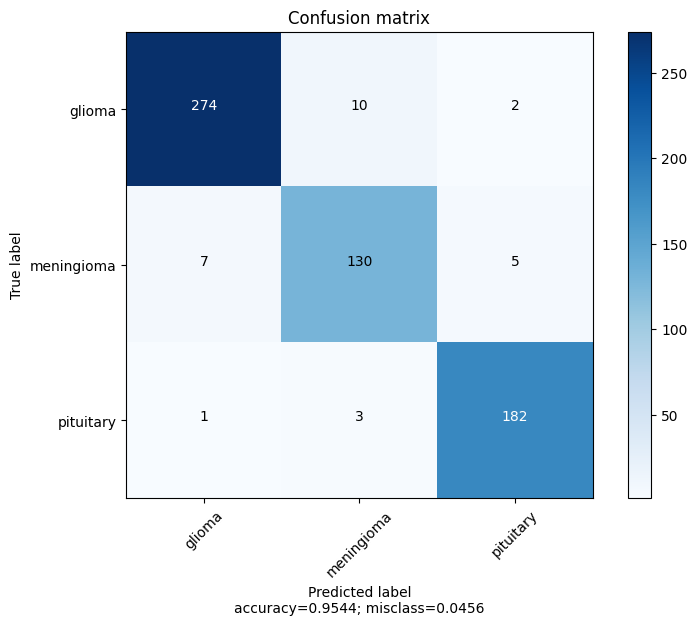

In [6]:
pred = model.predict(x_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)
loss,acc = model.evaluate(x_test,y_test,verbose = 1)
draw_matrix(labels, y_test_new, pred, acc)

In [7]:
%reset -f

100%|██████████| 186/186 [00:00<00:00, 195.76it/s]


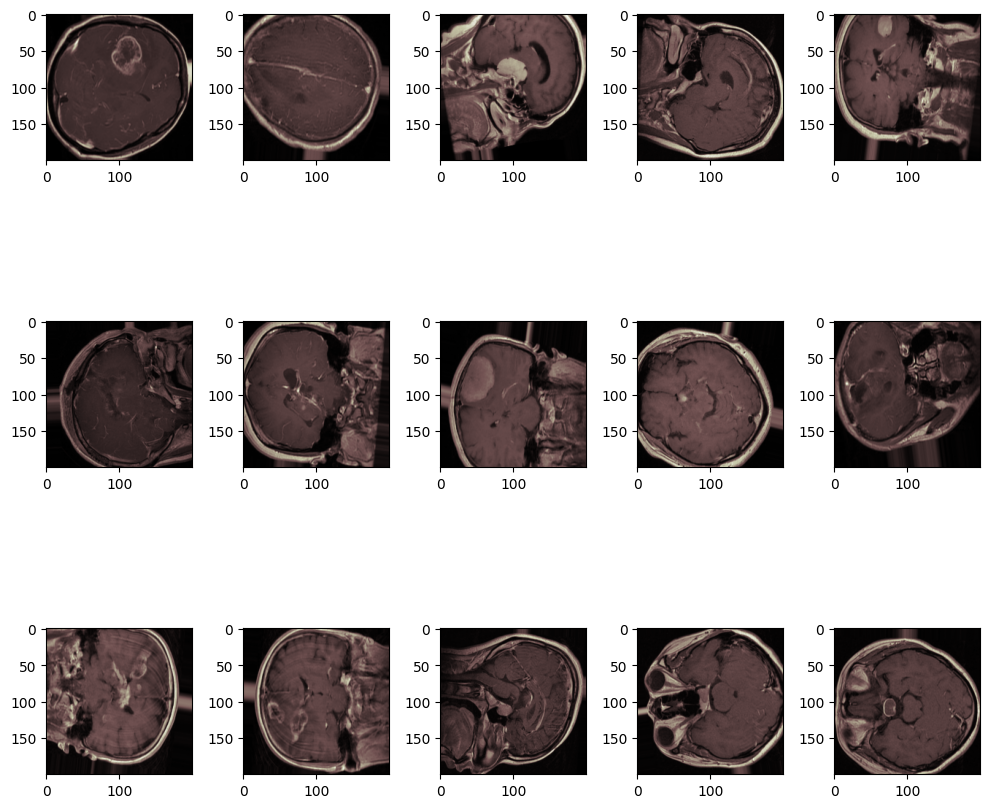

(614, 200, 200, 3)
(10536, 200, 200, 3)
(614, 3)
(10536, 3)
Epoch 1/50
263/264 [============================>.] - ETA: 0s - loss: 0.8388 - accuracy: 0.6461
Epoch 1: saving model to model-InceptionV3.h5
Epoch 1: 16.94 seconds
264/264 [==============================] - 17s 47ms/step - loss: 0.8385 - accuracy: 0.6463 - val_loss: 3.9088 - val_accuracy: 0.3321 - lr: 1.0000e-04
Epoch 2/50
263/264 [============================>.] - ETA: 0s - loss: 0.5053 - accuracy: 0.7994
Epoch 2: saving model to model-InceptionV3.h5
Epoch 2: 11.37 seconds
264/264 [==============================] - 11s 43ms/step - loss: 0.5055 - accuracy: 0.7994 - val_loss: 1.6577 - val_accuracy: 0.5275 - lr: 1.0000e-04
Epoch 3/50
263/264 [============================>.] - ETA: 0s - loss: 0.3618 - accuracy: 0.8606
Epoch 3: saving model to model-InceptionV3.h5
Epoch 3: 11.11 seconds
264/264 [==============================] - 11s 42ms/step - loss: 0.3617 - accuracy: 0.8606 - val_loss: 0.3448 - val_accuracy: 0.8672 - lr: 1.0000

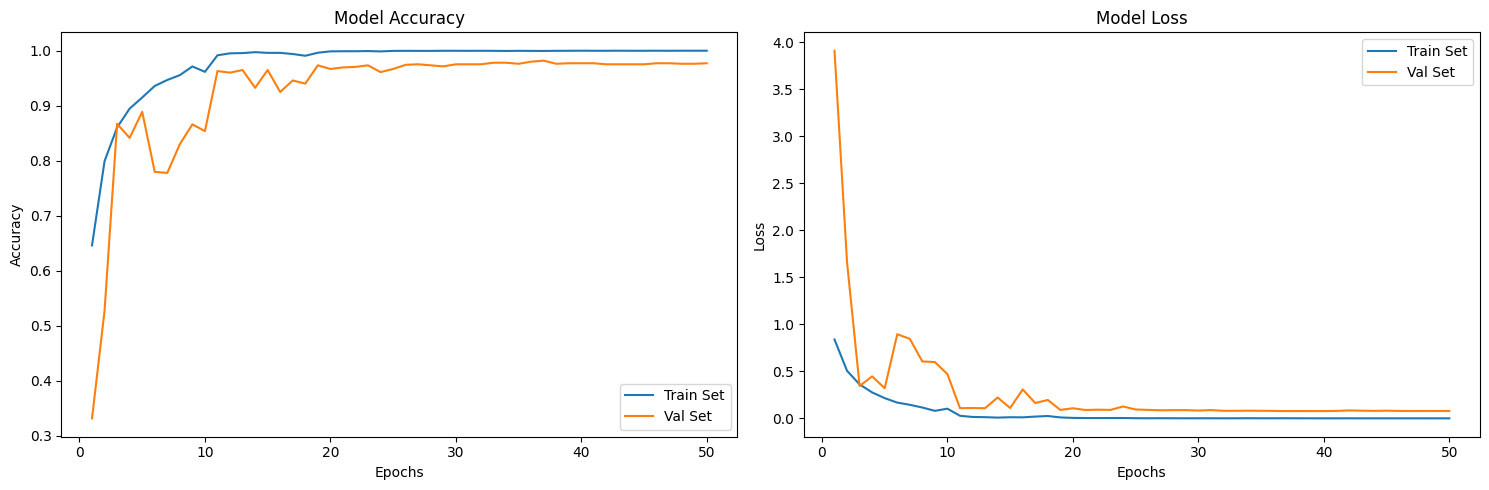

20/20 [==============================] - 0s 14ms/step - loss: 0.1773 - accuracy: 0.9593
Test Accuracy:  95.93
              precision    recall  f1-score   support

      glioma     0.9822    0.9650    0.9735       286
  meningioma     0.9225    0.9225    0.9225       142
   pituitary     0.9529    0.9785    0.9655       186

    accuracy                         0.9593       614
   macro avg     0.9525    0.9554    0.9539       614
weighted avg     0.9595    0.9593    0.9593       614



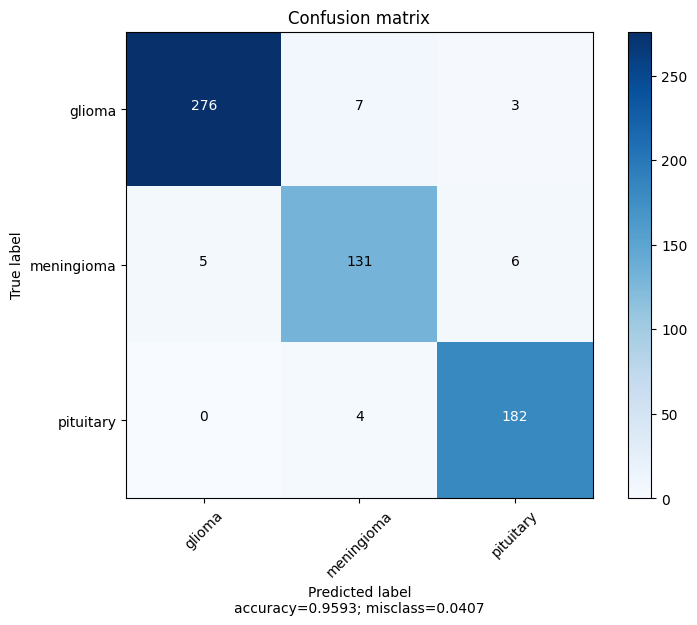

In [9]:
labels = ['glioma', 'meningioma', 'pituitary']
data_path = '/root/autodl-tmp/dataset/figshare_MBTD/augmented'
image_size = 200
x_train, x_test, y_train, y_test = load_data(data_path, labels, image_size)


net = InceptionV3(weights=None, include_top=False, input_shape=(image_size, image_size, 3))
model = net.output
model = GlobalAveragePooling2D()(model)
model = Dropout(0.5)(model)
model = Dense(3, activation="softmax")(model)
model = Model(inputs=net.input, outputs=model)
adam = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])


tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint(filepath='model-InceptionV3.h5',
                             monitor='val_accuracy', verbose=1, save_best_only=False, mode='max')
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 5, min_delta = 0.001,
                              mode='auto',verbose=1)
time_callback = TimeHistory()
history = model.fit(x_train,y_train,validation_split=0.1, epochs =50, verbose=1, batch_size=36,
                   callbacks=[tensorboard,checkpoint,reduce_lr, time_callback])


draw_curve(history)
pred = model.predict(x_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)
loss,acc = model.evaluate(x_test,y_test,verbose = 1)
draw_matrix(labels, y_test_new, pred, acc)
%reset -f


100%|██████████| 186/186 [00:00<00:00, 195.36it/s]


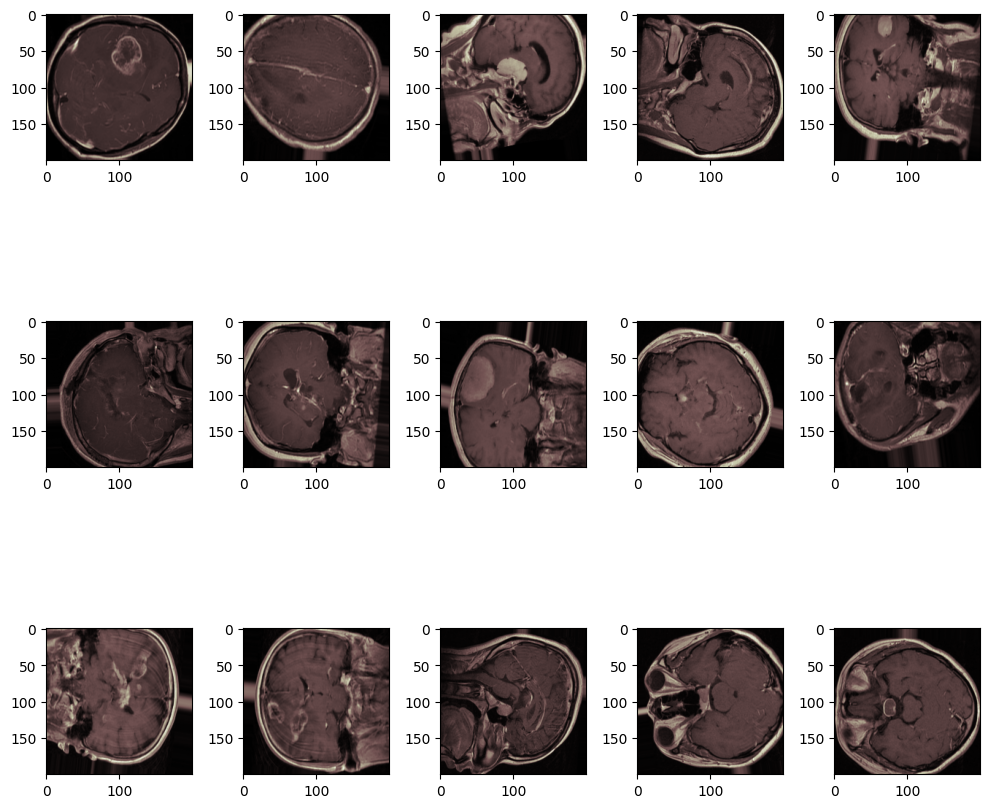

(614, 200, 200, 3)
(10536, 200, 200, 3)
(614, 3)
(10536, 3)


2023-12-09 14:41:23.607108: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-09 14:41:23.911732: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22134 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:c3:00.0, compute capability: 8.9


Epoch 1/50


2023-12-09 14:41:34.909707: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8101
2023-12-09 14:41:35.497436: W tensorflow/stream_executor/gpu/asm_compiler.cc:230] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.9
2023-12-09 14:41:35.497462: W tensorflow/stream_executor/gpu/asm_compiler.cc:233] Used ptxas at ptxas
2023-12-09 14:41:35.497582: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] UNIMPLEMENTED: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2023-12-09 14:41:36.153365: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


264/264 [==============================] - ETA: 0s - loss: 0.8183 - accuracy: 0.6534
Epoch 1: saving model to model-InceptionV3.h5
Epoch 1: 20.49 seconds
264/264 [==============================] - 20s 51ms/step - loss: 0.8183 - accuracy: 0.6534 - val_loss: 3.5999 - val_accuracy: 0.3321 - lr: 1.0000e-04
Epoch 2/50
263/264 [============================>.] - ETA: 0s - loss: 0.5204 - accuracy: 0.7967
Epoch 2: saving model to model-InceptionV3.h5
Epoch 2: 11.67 seconds
264/264 [==============================] - 12s 44ms/step - loss: 0.5202 - accuracy: 0.7968 - val_loss: 2.8233 - val_accuracy: 0.3634 - lr: 1.0000e-04
Epoch 3/50
263/264 [============================>.] - ETA: 0s - loss: 0.3740 - accuracy: 0.8563
Epoch 3: saving model to model-InceptionV3.h5
Epoch 3: 11.62 seconds
264/264 [==============================] - 12s 44ms/step - loss: 0.3738 - accuracy: 0.8563 - val_loss: 0.6914 - val_accuracy: 0.7694 - lr: 1.0000e-04
Epoch 4/50
263/264 [============================>.] - ETA: 0s - lo

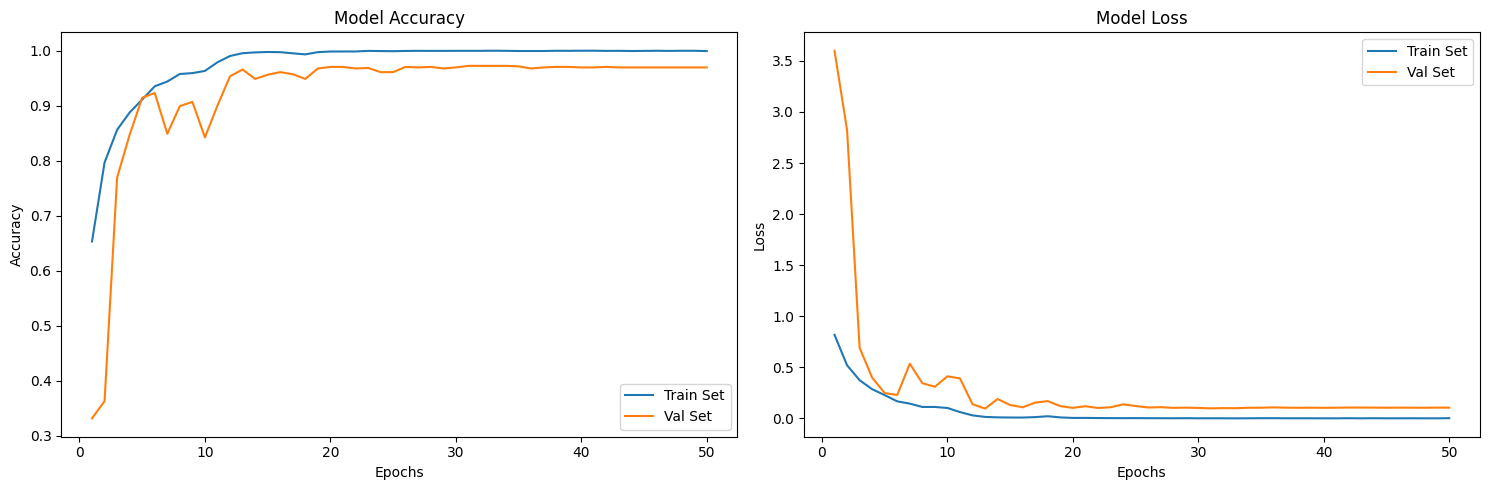

20/20 [==============================] - 0s 15ms/step - loss: 0.2000 - accuracy: 0.9511
Test Accuracy:  95.11
              precision    recall  f1-score   support

      glioma     0.9650    0.9650    0.9650       286
  meningioma     0.9191    0.8803    0.8993       142
   pituitary     0.9531    0.9839    0.9683       186

    accuracy                         0.9511       614
   macro avg     0.9458    0.9431    0.9442       614
weighted avg     0.9508    0.9511    0.9508       614



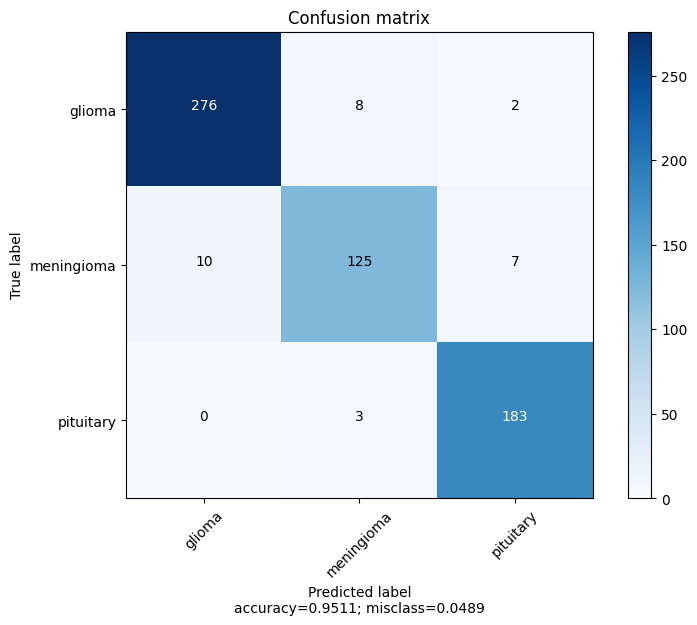

In [2]:
labels = ['glioma', 'meningioma', 'pituitary']
data_path = '/root/autodl-tmp/dataset/figshare_MBTD/augmented'
image_size = 200
x_train, x_test, y_train, y_test = load_data(data_path, labels, image_size)


net = InceptionV3(weights=None, include_top=False, input_shape=(image_size, image_size, 3))
model = net.output
model = GlobalAveragePooling2D()(model)
model = Dropout(0.5)(model)
model = Dense(3, activation="softmax")(model)
model = Model(inputs=net.input, outputs=model)
adam = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])


tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint(filepath='model-InceptionV3.h5',
                             monitor='val_accuracy', verbose=1, save_best_only=False, mode='max')
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 5, min_delta = 0.001,
                              mode='auto',verbose=1)
time_callback = TimeHistory()
history = model.fit(x_train,y_train,validation_split=0.1, epochs =50, verbose=1, batch_size=36,
                   callbacks=[tensorboard,checkpoint,reduce_lr, time_callback])


draw_curve(history)
pred = model.predict(x_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)
loss,acc = model.evaluate(x_test,y_test,verbose = 1)
draw_matrix(labels, y_test_new, pred, acc)
%reset -f

100%|██████████| 186/186 [00:00<00:00, 193.85it/s]


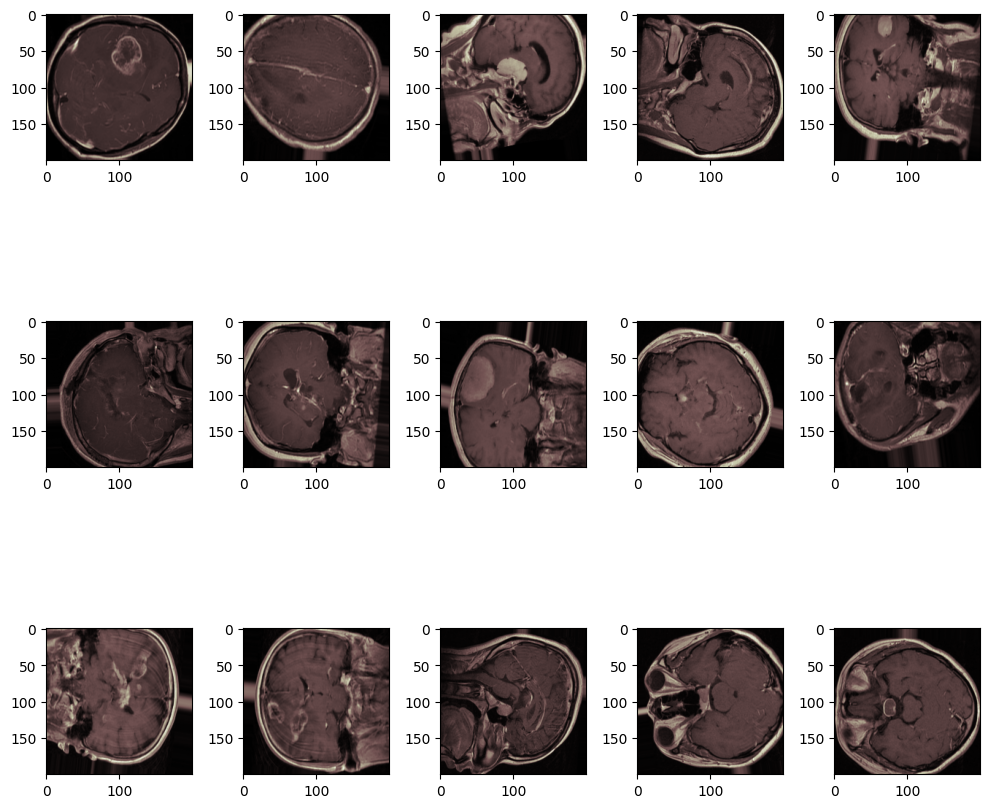

(614, 200, 200, 3)
(10536, 200, 200, 3)
(614, 3)
(10536, 3)
Epoch 1/50
263/264 [============================>.] - ETA: 0s - loss: 0.7931 - accuracy: 0.6641
Epoch 1: saving model to model-InceptionV3.h5
Epoch 1: 17.36 seconds
264/264 [==============================] - 17s 48ms/step - loss: 0.7939 - accuracy: 0.6640 - val_loss: 2.6666 - val_accuracy: 0.3321 - lr: 1.0000e-04
Epoch 2/50
263/264 [============================>.] - ETA: 0s - loss: 0.5046 - accuracy: 0.8012
Epoch 2: saving model to model-InceptionV3.h5
Epoch 2: 11.51 seconds
264/264 [==============================] - 12s 44ms/step - loss: 0.5044 - accuracy: 0.8013 - val_loss: 1.4749 - val_accuracy: 0.5493 - lr: 1.0000e-04
Epoch 3/50
263/264 [============================>.] - ETA: 0s - loss: 0.3716 - accuracy: 0.8548
Epoch 3: saving model to model-InceptionV3.h5
Epoch 3: 11.62 seconds
264/264 [==============================] - 12s 44ms/step - loss: 0.3714 - accuracy: 0.8548 - val_loss: 0.4887 - val_accuracy: 0.8226 - lr: 1.0000

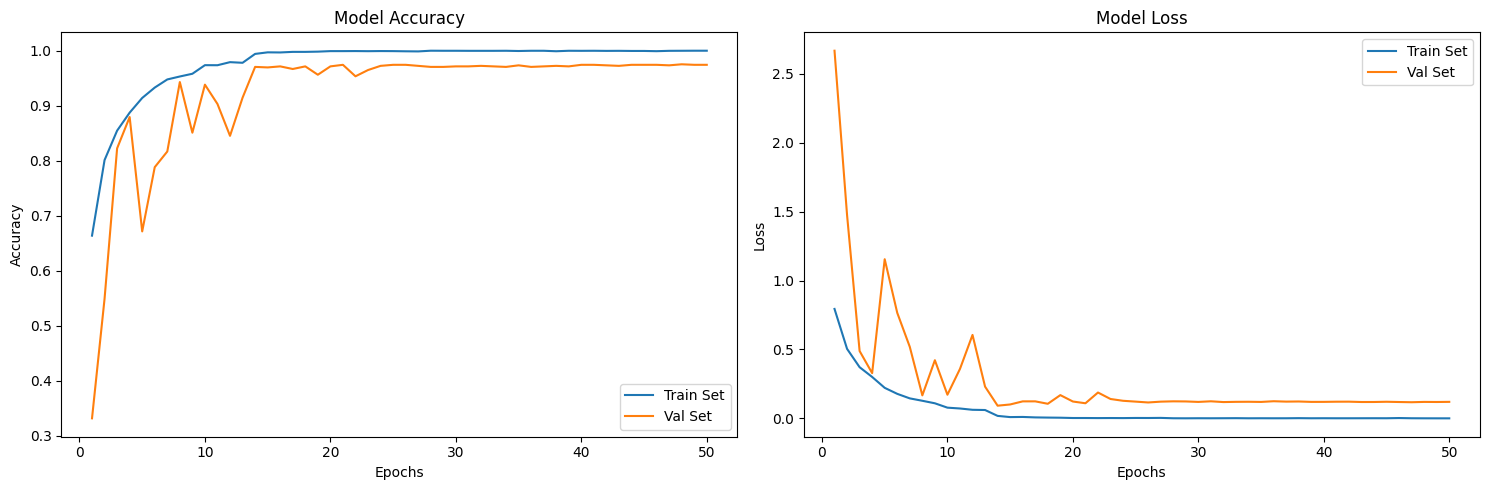

20/20 [==============================] - 0s 15ms/step - loss: 0.1642 - accuracy: 0.9609
Test Accuracy:  96.09
              precision    recall  f1-score   support

      glioma     0.9753    0.9650    0.9701       286
  meningioma     0.9362    0.9296    0.9329       142
   pituitary     0.9579    0.9785    0.9681       186

    accuracy                         0.9609       614
   macro avg     0.9564    0.9577    0.9570       614
weighted avg     0.9610    0.9609    0.9609       614



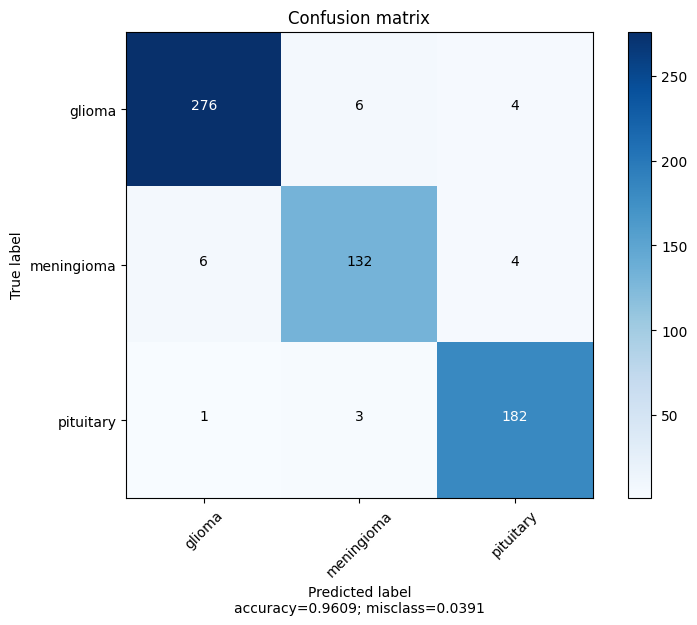

In [4]:
labels = ['glioma', 'meningioma', 'pituitary']
data_path = '/root/autodl-tmp/dataset/figshare_MBTD/augmented'
image_size = 200
x_train, x_test, y_train, y_test = load_data(data_path, labels, image_size)


net = InceptionV3(weights=None, include_top=False, input_shape=(image_size, image_size, 3))
model = net.output
model = GlobalAveragePooling2D()(model)
model = Dropout(0.5)(model)
model = Dense(3, activation="softmax")(model)
model = Model(inputs=net.input, outputs=model)
adam = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])


tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint(filepath='model-InceptionV3.h5',
                             monitor='val_accuracy', verbose=1, save_best_only=False, mode='max')
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 5, min_delta = 0.001,
                              mode='auto',verbose=1)
time_callback = TimeHistory()
history = model.fit(x_train,y_train,validation_split=0.1, epochs =50, verbose=1, batch_size=36,
                   callbacks=[tensorboard,checkpoint,reduce_lr, time_callback])


draw_curve(history)
pred = model.predict(x_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)
loss,acc = model.evaluate(x_test,y_test,verbose = 1)
draw_matrix(labels, y_test_new, pred, acc)

100%|██████████| 186/186 [00:00<00:00, 194.22it/s]


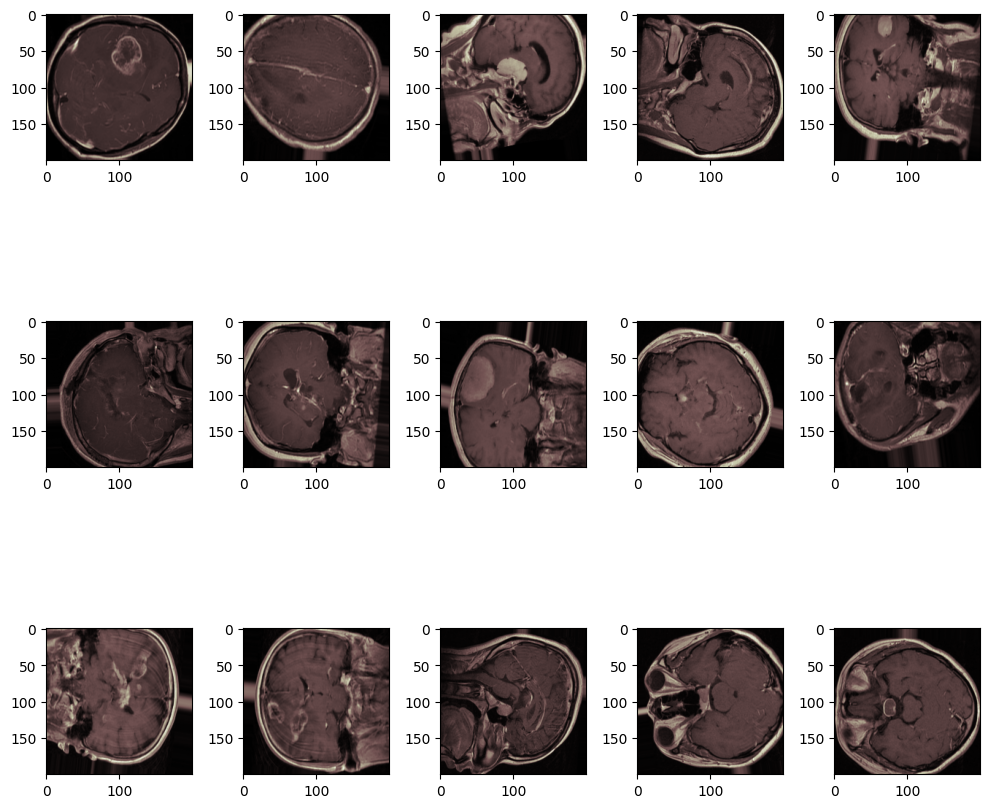

(614, 200, 200, 3)
(10536, 200, 200, 3)
(614, 3)
(10536, 3)
Epoch 1/50
263/264 [============================>.] - ETA: 0s - loss: 0.7994 - accuracy: 0.6605
Epoch 1: saving model to model-InceptionV3.h5
Epoch 1: 17.17 seconds
264/264 [==============================] - 17s 49ms/step - loss: 0.7989 - accuracy: 0.6606 - val_loss: 1.8329 - val_accuracy: 0.3757 - lr: 1.0000e-04
Epoch 2/50
263/264 [============================>.] - ETA: 0s - loss: 0.4790 - accuracy: 0.8128
Epoch 2: saving model to model-InceptionV3.h5
Epoch 2: 11.71 seconds
264/264 [==============================] - 12s 44ms/step - loss: 0.4783 - accuracy: 0.8131 - val_loss: 2.0124 - val_accuracy: 0.4658 - lr: 1.0000e-04
Epoch 3/50
263/264 [============================>.] - ETA: 0s - loss: 0.3511 - accuracy: 0.8699
Epoch 3: saving model to model-InceptionV3.h5
Epoch 3: 11.73 seconds
264/264 [==============================] - 12s 44ms/step - loss: 0.3510 - accuracy: 0.8700 - val_loss: 0.5239 - val_accuracy: 0.8008 - lr: 1.0000

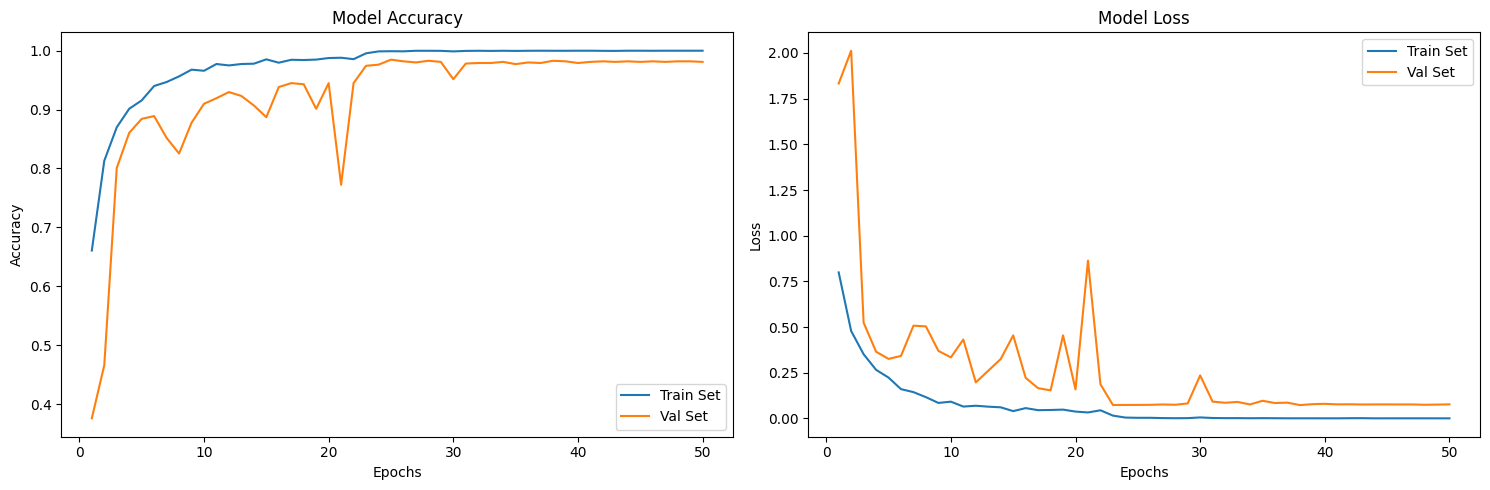

20/20 [==============================] - 0s 15ms/step - loss: 0.1093 - accuracy: 0.9739
Test Accuracy:  97.39
              precision    recall  f1-score   support

      glioma     0.9859    0.9755    0.9807       286
  meningioma     0.9444    0.9577    0.9510       142
   pituitary     0.9786    0.9839    0.9812       186

    accuracy                         0.9739       614
   macro avg     0.9696    0.9724    0.9710       614
weighted avg     0.9741    0.9739    0.9740       614



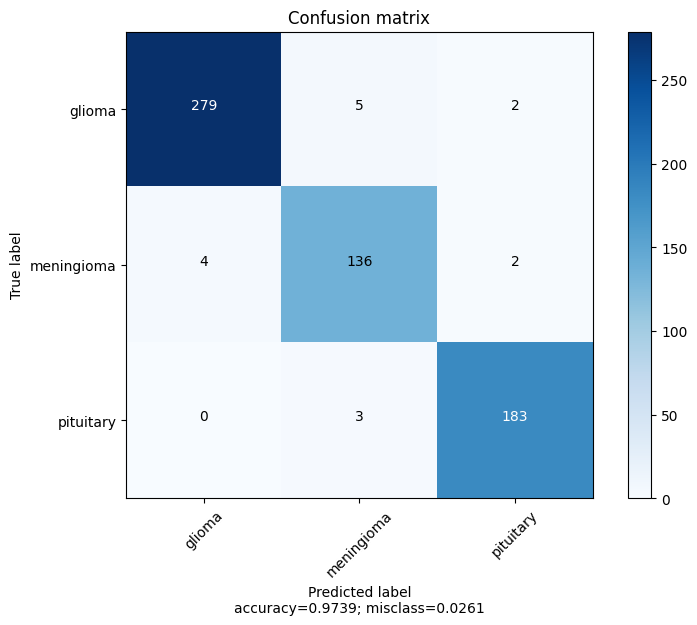

In [8]:
labels = ['glioma', 'meningioma', 'pituitary']
data_path = '/root/autodl-tmp/dataset/figshare_MBTD/augmented'
image_size = 200
x_train, x_test, y_train, y_test = load_data(data_path, labels, image_size)


net = InceptionV3(weights=None, include_top=False, input_shape=(image_size, image_size, 3))
model = net.output
model = GlobalAveragePooling2D()(model)
model = Dropout(0.5)(model)
model = Dense(3, activation="softmax")(model)
model = Model(inputs=net.input, outputs=model)
adam = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])


tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint(filepath='model-InceptionV3.h5',
                             monitor='val_accuracy', verbose=1, save_best_only=False, mode='max')
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 5, min_delta = 0.001,
                              mode='auto',verbose=1)
time_callback = TimeHistory()
history = model.fit(x_train,y_train,validation_split=0.1, epochs =50, verbose=1, batch_size=36,
                   callbacks=[tensorboard,checkpoint,reduce_lr, time_callback])


draw_curve(history)
pred = model.predict(x_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)
loss,acc = model.evaluate(x_test,y_test,verbose = 1)
draw_matrix(labels, y_test_new, pred, acc)